In [115]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.model_selection import train_test_split

from termcolor import colored
from fitter import Fitter, get_common_distributions


from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

In [116]:
#Configuraciones
plt.rcParams['image.cmap'] = 'bwr'
plt.rcParams['savefig.bbox'] = 'tight'
style.use('ggplot') or plt.style.use('ggplot')

#  Datos 

El conjunto de datos es SaratogaHouses del paquete mosaicData de R. Contiene información sobre el precio de 1728 viviendas situadas en Saratoga County, New York, USA en el año 2006. Además del precio, incluye 15 variables adicionales:

- **price**: precio de la vivienda.
- **lotSize**: metros cuadrados de la vivienda.
- **age**: antigüedad de la vivienda.
- **landValue**: valor del terreno.
- **livingArea**: metros cuadrados habitables.
- **pctCollege**: porcentaje del vecindario con título universitario.
- **bedrooms**: número de dormitorios.
- **firplaces**: número de chimeneas.
- **bathrooms**: número de cuartos de baño (el valor 0.5 hace referencia a cuartos de baño sin ducha).
- **rooms**: número de habitaciones.
- **heating**: tipo de calefacción.
- **fuel**: tipo de alimentación de la calefacción (gas, electricidad o diesel).
- **sewer**: tipo de desagüe.
- **waterfront**: si la vivienda tiene vistas al lago.
- **newConstruction**: si la vivienda es de nueva construcción.
- **centralAir**: si la vivienda tiene aire acondicionado.

In [117]:
# Se importan los datos de una fuente externa
url = "https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/master/data/SaratogaHouses.csv"
data = pd.read_csv(url)


# Se renombran las variables
data.columns = ["precio", "metros_totales", "antiguedad", "precio_terreno",
                 "metros_habitables", "universitarios", "dormitorios", 
                 "chimenea", "banyos", "habitaciones", "calefaccion",
                 "consumo_calefacion", "desague", "vistas_lago",
                 "nueva_construccion", "aire_acondicionado"]

data.head(1)

,precio,metros_totales,antiguedad,precio_terreno,metros_habitables,universitarios,dormitorios,chimenea,banyos,habitaciones,calefaccion,consumo_calefacion,desague,vistas_lago,nueva_construccion,aire_acondicionado
0,132500,0.09,42,50000,906,35,2,1,1.0,5,electric,electric,septic,No,No,No


###  Objetivo 
Predecir el precio de alquiler

#  Análisis exploratorio

In [118]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 16 columns):
precio                1728 non-null int64
metros_totales        1728 non-null float64
antiguedad            1728 non-null int64
precio_terreno        1728 non-null int64
metros_habitables     1728 non-null int64
universitarios        1728 non-null int64
dormitorios           1728 non-null int64
chimenea              1728 non-null int64
banyos                1728 non-null float64
habitaciones          1728 non-null int64
calefaccion           1728 non-null object
consumo_calefacion    1728 non-null object
desague               1728 non-null object
vistas_lago           1728 non-null object
nueva_construccion    1728 non-null object
aire_acondicionado    1728 non-null object
dtypes: float64(2), int64(8), object(6)
memory usage: 216.1+ KB


### Caracteristicas con tipo de dato incorrecto 
**Nota**:
- Concidero que las variables que hacen referencia al dinero y metros deberian ser variables continuas
- La variable baño es de naturaleza discreta

In [119]:
data['precio'] = data['precio'].astype('float64')
data['precio_terreno'] = data['precio_terreno'].astype('float64')
data['metros_habitables'] = data['metros_habitables'].astype('float64')
data['banyos'] = data['banyos'].astype('int64')

### Valores faltantes 

In [120]:
print(colored('No hay valores nulos', attrs = ['bold']))
data.isnull().sum()

No hay valores nulos


precio                0
metros_totales        0
antiguedad            0
precio_terreno        0
metros_habitables     0
universitarios        0
dormitorios           0
chimenea              0
banyos                0
habitaciones          0
calefaccion           0
consumo_calefacion    0
desague               0
vistas_lago           0
nueva_construccion    0
aire_acondicionado    0
dtype: int64

In [121]:
print(colored('Otro metodo (False: Valores no nulos), (True: Valores nulos)', attrs=['bold']))
available = data.isnull()
available = available.apply(pd.Series.value_counts)
available

Otro metodo (False: Valores no nulos), (True: Valores nulos)


,precio,metros_totales,antiguedad,precio_terreno,metros_habitables,universitarios,dormitorios,chimenea,banyos,habitaciones,calefaccion,consumo_calefacion,desague,vistas_lago,nueva_construccion,aire_acondicionado
False,1728,1728,1728,1728,1728,1728,1728,1728,1728,1728,1728,1728,1728,1728,1728,1728


### Variable respuesta

**Rug plot** es un tipo de gráfica que muestra la distribución de una variable con marcas representando las observaciones individuales de una manera discreta en un único eje. 

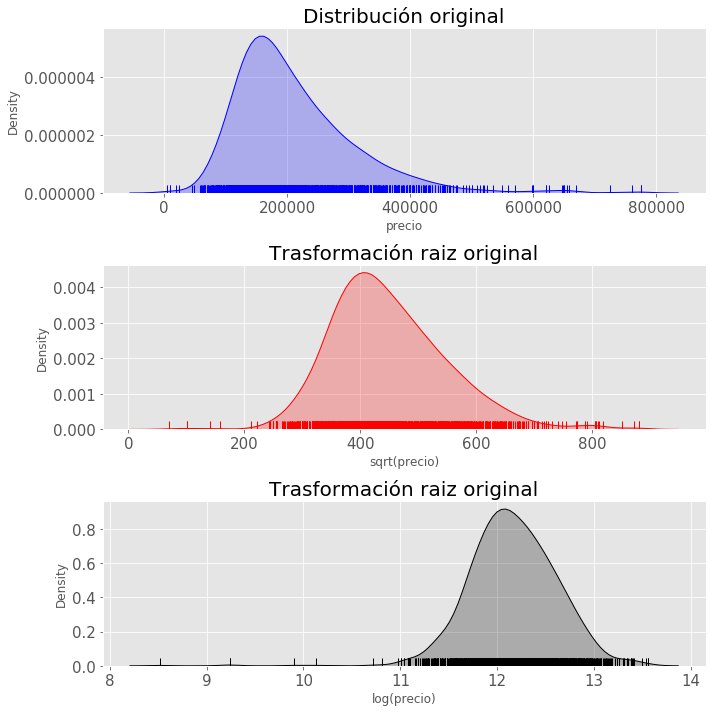

In [122]:
fig, ax = plt.subplots(nrows =3,ncols = 1, figsize = (10,10))

sns.distplot(data.precio, hist=False,rug=True,color = "blue",kde_kws = {'shade':True,'linewidth':1},ax=ax[0])
ax[0].set_title('Distribución original', size=20)
ax[0].tick_params(labelsize=15)
ax[0].set_xlabel('precio')
ax[0].set_ylabel('Density')

sns.distplot(np.sqrt(data.precio), hist=False, rug=True, color="red",kde_kws = {'shade':True,'linewidth':1},ax=ax[1])
ax[1].set_title('Trasformación raiz original', size=20)
ax[1].tick_params(labelsize=15)
ax[1].set_xlabel('sqrt(precio)')
ax[1].set_ylabel('Density')

sns.distplot(np.log(data.precio), hist=False, rug=True, color="black",kde_kws = {'shade':True,'linewidth':1},ax=ax[2])
ax[2].set_title('Trasformación raiz original', size=20)
ax[2].tick_params(labelsize=15)
ax[2].set_xlabel('log(precio)')
ax[2].set_ylabel('Density')

fig.tight_layout()

,sumsquare_error,aic,bic,kl_div
beta,2.497420e-11,3068.852573,-55037.908642,inf
logistic,4.913880e-11,3147.967019,-53883.297831,inf
cauchy,5.221450e-11,2956.669693,-53778.388707,inf
chi2,5.776892e-11,3321.818880,-53596.249282,inf
norm,6.947514e-11,3324.534158,-53284.856663,inf
expon,2.915346e-10,2824.103160,-50806.577128,inf
powerlaw,3.078034e-10,2741.669837,-50705.287086,inf
exponpow,4.841645e-10,inf,-49922.566370,NaN
gamma,4.841645e-10,inf,-49922.566370,3.958212


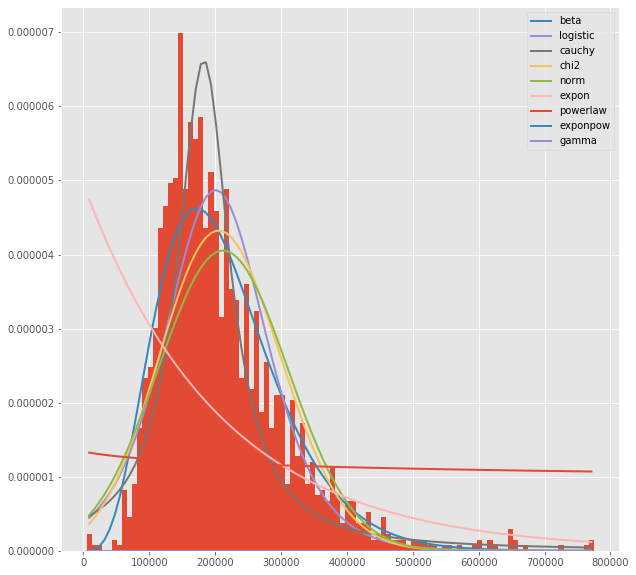

In [123]:
distribuciones = ['cauchy','chi2','expon','exponpow','gamma','norm','powerlaw', 'beta', 'logistic']
fig, ax = plt.subplots(nrows =1,ncols = 1, figsize = (10,10))
fitter = Fitter(data.precio, distributions = distribuciones)
fitter.fit()
fitter.summary(Nbest=10, plot=True)

### Variables cuantitativas

In [124]:
data.select_dtypes(include = ['int64','float64']).describe()

,precio,metros_totales,antiguedad,precio_terreno,metros_habitables,universitarios,dormitorios,chimenea,banyos,habitaciones
count,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000
mean,211966.705440,0.500214,27.916088,34557.187500,1754.975694,55.567708,3.154514,0.601852,1.586806,7.041667
std,98441.391015,0.698680,29.209988,35021.168056,619.935553,10.333581,0.817351,0.556102,0.617717,2.316453
min,5000.000000,0.000000,0.000000,200.000000,616.000000,20.000000,1.000000,0.000000,0.000000,2.000000
25%,145000.000000,0.170000,13.000000,15100.000000,1300.000000,52.000000,3.000000,0.000000,1.000000,5.000000
50%,189900.000000,0.370000,19.000000,25000.000000,1634.500000,57.000000,3.000000,1.000000,2.000000,7.000000
75%,259000.000000,0.540000,34.000000,40200.000000,2137.750000,64.000000,4.000000,1.000000,2.000000,8.250000
max,775000.000000,12.200000,225.000000,412600.000000,5228.000000,82.000000,7.000000,4.000000,4.000000,12.000000


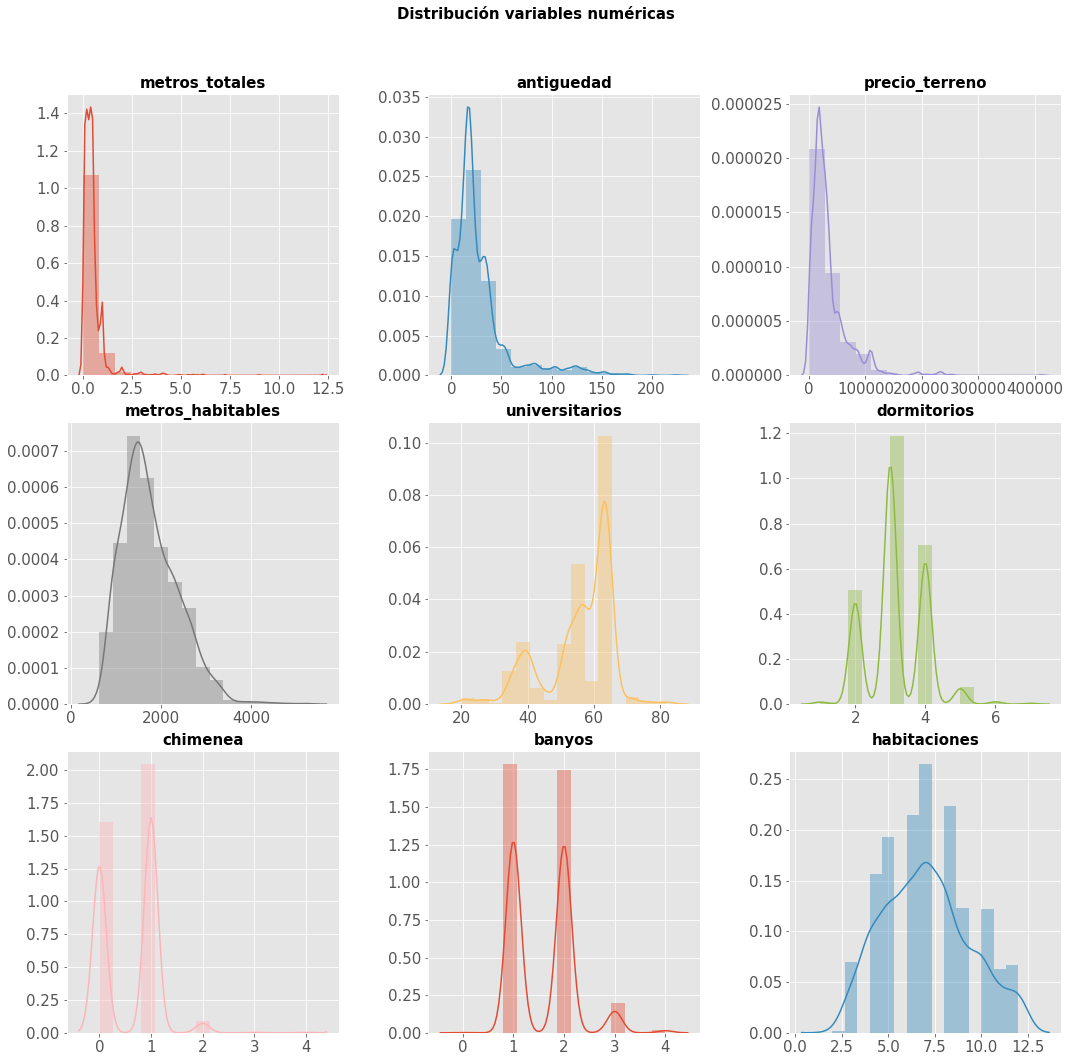

In [125]:
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (15,15))
ax = ax.flat
columns_numeric = data.select_dtypes(include = ['int64','float64']).drop('precio',axis=1).columns

for i, col in enumerate(columns_numeric):
    sns.distplot(data[col], bins = 15, kde=True,color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],ax=ax[i])
    
    ax[i].set_title(col,size = 15, fontweight = "bold")
    ax[i].tick_params(labelsize = 15)
    ax[i].set_xlabel("",size=15)
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 15, fontweight = "bold");

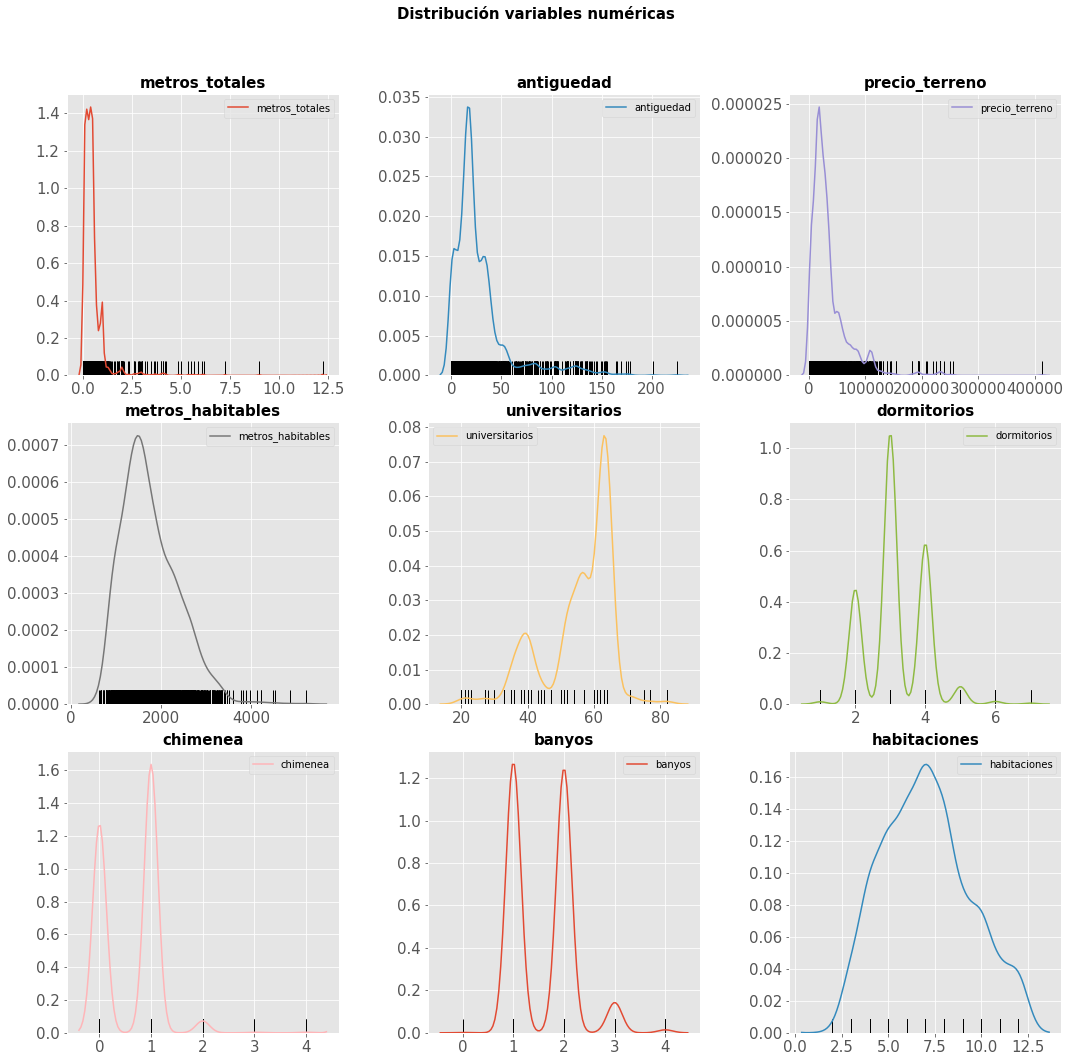

In [126]:
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (15,15))
ax = ax.flat
columns_numeric = data.select_dtypes(include = ['int64','float64']).drop('precio',axis = 1).columns
for i, col in enumerate(columns_numeric):
    sns.kdeplot(data[col], color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],ax=ax[i])
    sns.rugplot(data[col], ax=ax[i], color   = 'black')
    
    ax[i].set_title(col,size = 15, fontweight = "bold")
    ax[i].tick_params(labelsize = 15)
    ax[i].set_xlabel("",size=15)
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 15, fontweight = "bold");

**Nota**
- La variable **chimenea**, es numerica, pero apenas toma unos pocos valores y la gran mayoria de observaciones pertenecen a solo dos de ellos. De acuerdo a la recomendación del instructor es conveniente tratar la variable como cualitativa.
- Basandome de la premisa anterior, entonces la variable **baños** tambien deberia se conciderada como cualitativa, pero para no afectar la capacitación seguire las instrucciones planteadas en este *workshop*.

In [127]:
print(colored('Valores observados de Baños', attrs=['bold']))
data.banyos.value_counts()

Valores observados de Baños


1    822
2    804
3     92
4      9
0      1
Name: banyos, dtype: int64

In [128]:
print(colored('Valores observados de chimenea', attrs=['bold']))
data.chimenea.value_counts()

Valores observados de chimenea


1    942
0    740
2     42
4      2
3      2
Name: chimenea, dtype: int64

In [129]:
print(colored('Convertir la variable chimenea en tipo string', attrs=['bold']))

data['chimenea'] = data['chimenea'].astype('object')
data.chimenea.dtypes

Convertir la variable chimenea en tipo string


dtype('O')

### Variable cuantitativas vs respuesta

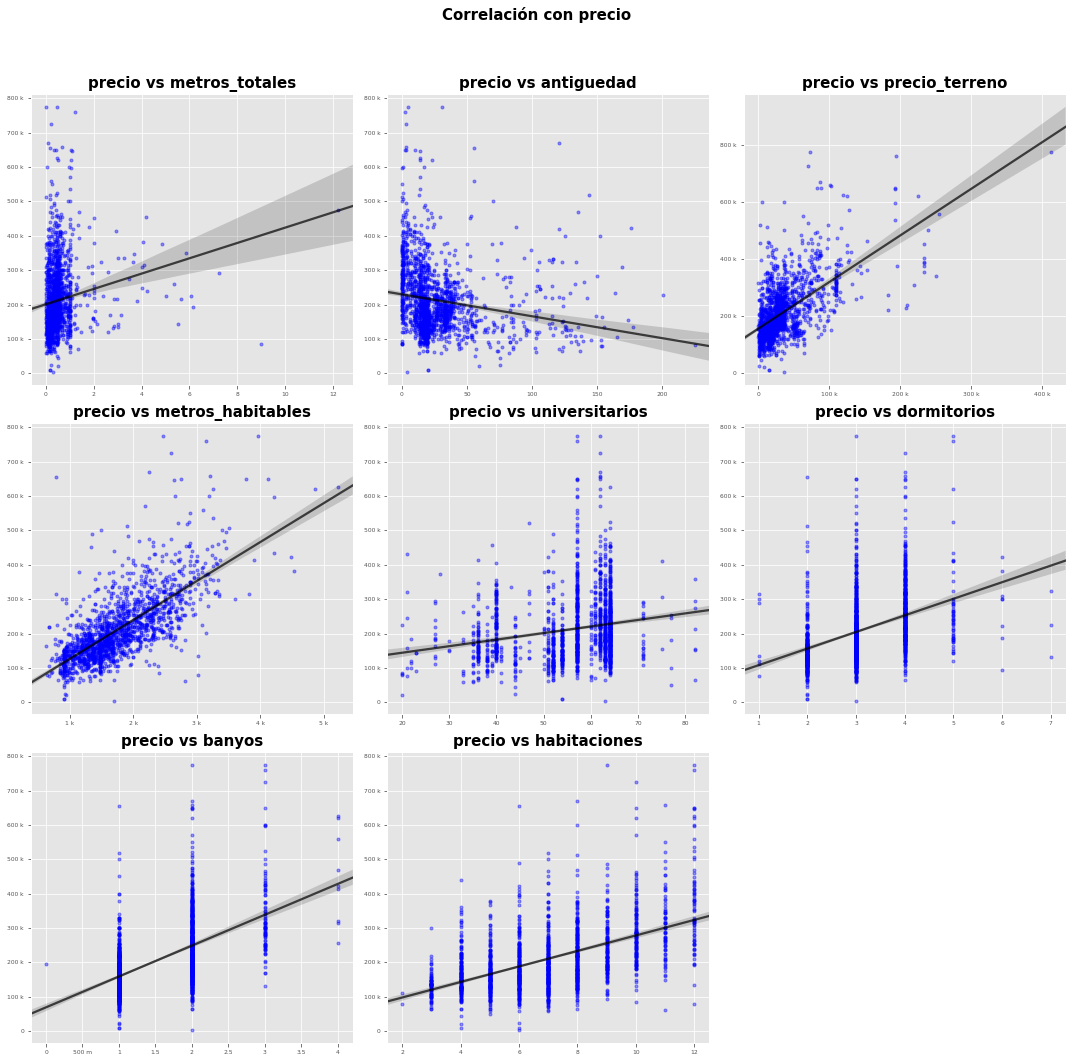

In [130]:
fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(15,15))
ax = ax.flat
colnumericas = data.select_dtypes(include = ['int64','float64']).drop('precio',axis=1).columns
for i, col in enumerate(colnumericas):
    sns.regplot(x=data[col],y=data['precio'], color='blue',marker = '.',scatter_kws = {"alpha":0.4},line_kws= {"color":"black","alpha":0.7},ax=ax[i])
    ax[i].set_title(f"precio vs {col}", size=15,fontweight = "bold")
    ax[i].yaxis.set_major_formatter(ticker.EngFormatter())
    ax[i].xaxis.set_major_formatter(ticker.EngFormatter())
    ax[i].tick_params(labelsize = 6)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")

for i in [8]:
    fig.delaxes(ax[i])
    

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Correlación con precio', fontsize = 15, fontweight = "bold");

### Correlación variables númericas

In [131]:
print(colored('Correlación entre columnas númericas', attrs=['bold']))
def tidy_corr_matrix(corr_mat):
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'],:]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    return corr_mat

corr_matrix = data.select_dtypes(include=['int64','float64']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

Correlación entre columnas númericas


,variable_1,variable_2,r,abs_r
44,metros_habitables,habitaciones,0.733666,0.733666
76,habitaciones,metros_habitables,0.733666,0.733666
36,metros_habitables,precio,0.712390,0.712390
4,precio,metros_habitables,0.712390,0.712390
78,habitaciones,dormitorios,0.671863,0.671863
62,dormitorios,habitaciones,0.671863,0.671863
42,metros_habitables,dormitorios,0.656196,0.656196
58,dormitorios,metros_habitables,0.656196,0.656196
67,banyos,metros_habitables,0.642170,0.642170
43,metros_habitables,banyos,0.642170,0.642170


**Análisis**
- No hay variables con una correlación muy fuerte.
- Los posibles predictores no tienen una correlación muy débil con la variable objetivo, por lo tanto no es necesario eliminar alguno bajo este criterio.

Heatmap matriz de correlaciones


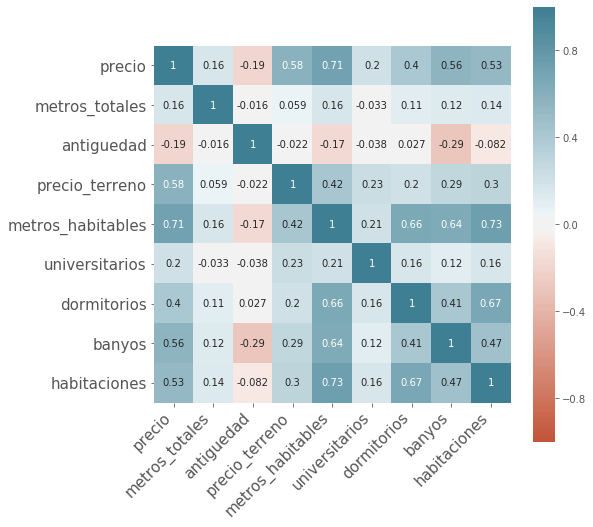

In [132]:
print(colored('Heatmap matriz de correlaciones', attrs=['bold']))
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(8,8))

sns.heatmap(
    corr_matrix,
    annot = True,
    cbar = True,
    annot_kws = {"size": 10},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right'
)
ax.tick_params(labelsize = 15)

### <font color = blue> Variables cualitativas </font>

In [133]:
data.select_dtypes(include =['object']).describe()

,chimenea,calefaccion,consumo_calefacion,desague,vistas_lago,nueva_construccion,aire_acondicionado
count,1728,1728,1728,1728,1728,1728,1728
unique,5,3,3,3,2,2,2
top,1,hot air,gas,public/commercial,No,No,No
freq,942,1121,1197,1213,1713,1647,1093


Variable cualitativa


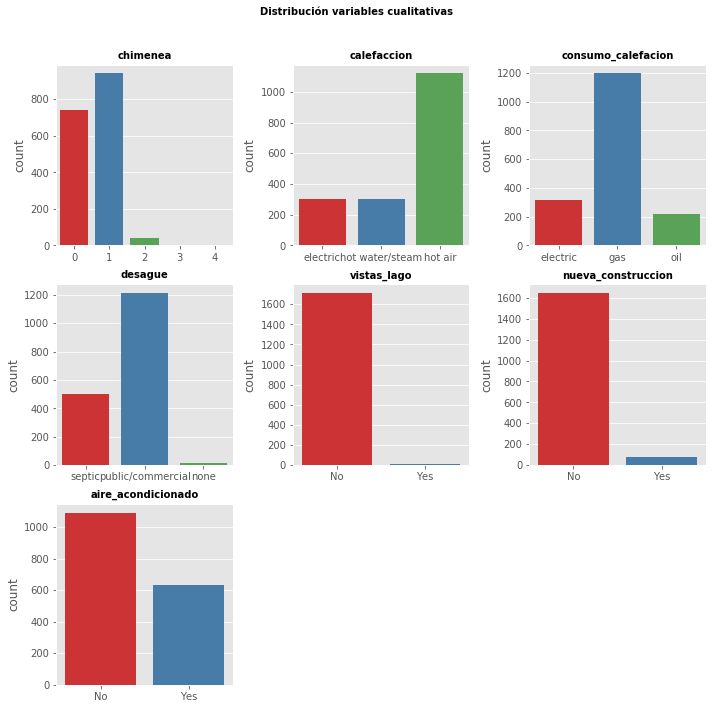

In [134]:
print(colored('Variable cualitativa', attrs=['bold']))

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
axes = axes.flat
columnas_object = data.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    sns.countplot(x=colum, data=data, palette="Set1", ax = axes[i])
    axes[i].set_title(colum, fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 10)
    axes[i].set_xlabel("")

# Se eliminan los axes vacíos
for i in [7, 8]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables cualitativas',
             fontsize = 10, fontweight = "bold");

**Nota**
- Deacuerdo al instructor es recomendable unificar los niveles 2,3 y 4 en un solo nivel llamado "2_mas".
- Faltaria aclarar a que se refiere con niveles

In [135]:
data.chimenea.value_counts().sort_index()

0    740
1    942
2     42
3      2
4      2
Name: chimenea, dtype: int64

In [136]:
data['chimenea'] = data['chimenea'].replace({1:'1',0:'0',2:'2_mas', 3:'2_mas',4:'2_mas'})

In [137]:
data.chimenea.value_counts()

1        942
0        740
2_mas     46
Name: chimenea, dtype: int64

###  Variables cualitativas vs precio 

Gráfico relación entre el precio y cada cada variables cualitativas


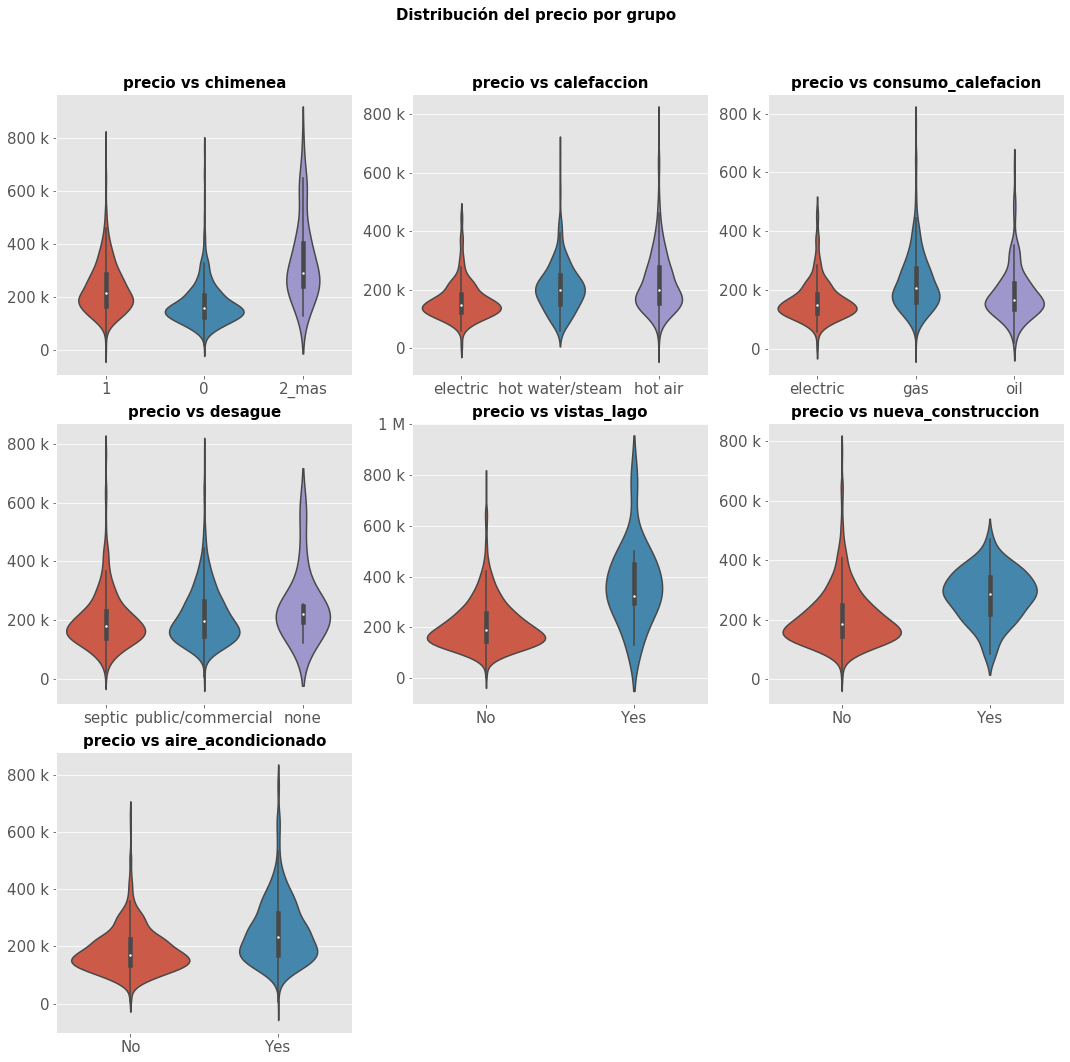

In [138]:
print(colored('Gráfico relación entre el precio y cada cada variables cualitativas', attrs=['bold']))
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (15,15))
ax = ax.flat
variables_categoricas = data.select_dtypes(include=['O']).columns
for i, col in enumerate(variables_categoricas):
    sns.violinplot(
        x = col,
        y = 'precio',
        data = data,
        ax = ax[i]
    )
    
    ax[i].set_title(f"precio vs {col}", fontsize = 15, fontweight = "bold")
    ax[i].yaxis.set_major_formatter(ticker.EngFormatter())
    ax[i].tick_params(labelsize = 15)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    
# Se eliminan los axes vacíos
for i in [7, 8]:
    fig.delaxes(ax[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución del precio por grupo', fontsize = 15, fontweight = "bold");

### División train y test 

**Nota**<br>
Aclaro que sigo las instrucciones del tutor, por lo general prefiero un 70%-30%

In [139]:
data_numeric = data.select_dtypes(include = ['int64','float64']).columns.to_list()
data_categoric = data.select_dtypes(include = ['object']).columns.to_list()
data = data.reindex(columns = data_numeric+data_categoric)

In [140]:
print(colored('Partición de los datos', attrs=['bold']))



y = data['precio']
X = data.drop('precio',axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

Partición de los datos


**Nota**
- Comprendo las particiones, de tener una distribución similar y de la partición estratificada (Por lo general esto se hace mas que todo en conjuntos desbalanceados).
- No combrendo por que hace un . describe en la variable objetivo. Como puedo visualizar lo anterior?

In [141]:
print(colored('Partición de entrenamento', attrs=['bold']))
print(colored('-----------------------', attrs=['bold']))
print(colored(y_train.describe(), attrs=['bold']))

Partición de entrenamento
-----------------------
count      1382.000000
mean     212198.766281
std       98075.727021
min        5000.000000
25%      145000.000000
50%      190700.000000
75%      258596.500000
max      775000.000000
Name: precio, dtype: float64


In [142]:
print(colored('Partición de test', color = 'blue', attrs=['bold']))
print(colored('-----------------------', attrs=['bold']))
print(colored(y_test.describe(), color = 'blue', attrs=['bold']))

Partición de test
-----------------------
count       346.000000
mean     211039.803468
std      100026.818095
min       10300.000000
25%      145000.000000
50%      183000.000000
75%      259175.000000
max      650000.000000
Name: precio, dtype: float64


# Preprocesado

### Imputación de valores ausentes

In [143]:
print(colored('No hay valores nulos', color = 'blue', attrs=['bold']))
data.isnull().sum()

No hay valores nulos


precio                0
metros_totales        0
antiguedad            0
precio_terreno        0
metros_habitables     0
universitarios        0
dormitorios           0
banyos                0
habitaciones          0
chimenea              0
calefaccion           0
consumo_calefacion    0
desague               0
vistas_lago           0
nueva_construccion    0
aire_acondicionado    0
dtype: int64

### Binarización de las variables cualitativas

In [144]:
data_categoric_X_train = X_train[data_categoric]
data_categoric_X_test = X_test[data_categoric]
one_hot = OneHotEncoder()
one_hot.fit_transform(data_categoric_X_train)
one_hot.transform(data_categoric_X_test)
data_dummy_train = pd.get_dummies(data_categoric_X_train)
data_dummy_test = pd.get_dummies(data_categoric_X_test)

In [145]:
X_train = X_train.drop(data_categoric,axis = 1)
X_test = X_test.drop(data_categoric,axis = 1)

In [146]:
X_train = pd.concat([X_train,data_dummy_train], axis = 1)
X_test = pd.concat([X_test,data_dummy_test], axis = 1)

### Excluir variables con varianza cero

In [147]:
X_train.columns

Index(['metros_totales', 'antiguedad', 'precio_terreno', 'metros_habitables',
       'universitarios', 'dormitorios', 'banyos', 'habitaciones', 'chimenea_0',
       'chimenea_1', 'chimenea_2_mas', 'calefaccion_electric',
       'calefaccion_hot air', 'calefaccion_hot water/steam',
       'consumo_calefacion_electric', 'consumo_calefacion_gas',
       'consumo_calefacion_oil', 'desague_none', 'desague_public/commercial',
       'desague_septic', 'vistas_lago_No', 'vistas_lago_Yes',
       'nueva_construccion_No', 'nueva_construccion_Yes',
       'aire_acondicionado_No', 'aire_acondicionado_Yes'],
      dtype='object')

In [148]:
estimador = VarianceThreshold(threshold = 0.03)
estimador = estimador.fit(X_train, y_train)

In [149]:
cols = estimador.get_support(indices = True)
cols

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16, 18,
       19, 22, 23, 24, 25], dtype=int64)

In [150]:
X_train.columns[cols]

Index(['metros_totales', 'antiguedad', 'precio_terreno', 'metros_habitables',
       'universitarios', 'dormitorios', 'banyos', 'habitaciones', 'chimenea_0',
       'chimenea_1', 'calefaccion_electric', 'calefaccion_hot air',
       'calefaccion_hot water/steam', 'consumo_calefacion_electric',
       'consumo_calefacion_gas', 'consumo_calefacion_oil',
       'desague_public/commercial', 'desague_septic', 'nueva_construccion_No',
       'nueva_construccion_Yes', 'aire_acondicionado_No',
       'aire_acondicionado_Yes'],
      dtype='object')

In [151]:
print(colored('Variables con poca varianza muy cercana a cero ¿Se deben excluir? depende del dominio del problema', color = 'blue', attrs=['bold']))

X_train.columns[[10,17,20,21]]

Variables con poca varianza muy cercana a cero ¿Se deben excluir? depende del dominio del problema


Index(['chimenea_2_mas', 'desague_none', 'vistas_lago_No', 'vistas_lago_Yes'], dtype='object')

In [152]:
print(colored('Consideró que las observaciones de desagüe y vista al lago deben permanecer, ya que pueden influir de cierta manera con el precio', color = 'blue', attrs=['bold']))


Consideró que las observaciones de desagüe y vista al lago deben permanecer, ya que pueden influir de cierta manera con el precio


In [153]:
print(colored('Elimino chimenea_2_mas', color = 'blue', attrs=['bold']))

X_train = X_train.drop('chimenea_2_mas',axis=1)
X_test = X_test.drop('chimenea_2_mas',axis=1)

Elimino chimenea_2_mas


# Estandarización y escalado de variables numéricas

In [174]:
data_numeric= X_train.select_dtypes(include = ['int64','float64']).columns.to_list()

In [193]:
data_temp_train = pd.concat([y_train, X_train],axis = 1)
data_temp_test = pd.concat([y_test, X_test],axis = 1)

In [194]:
estandarizacion = ColumnTransformer([('scale',StandardScaler(),data_numeric)], remainder='passthrough')

In [196]:
p_tr = estandarizacion.fit_transform(data_temp_train)
p_ts = estandarizacion.transform(data_temp_test)

In [201]:
p_tr = pd.DataFrame(p_tr,columns = data_temp_train.columns)
p_ts = pd.DataFrame(p_ts,columns = data_temp_test.columns)

In [203]:
X_train = p_tr.drop('precio',axis = True)
X_test = p_ts.drop('precio',axis = True)
y_train = p_tr['precio']
y_test = p_ts['precio']